Cell 1 complete — deconvolved_images ready.
Processed 31 images in full mode.


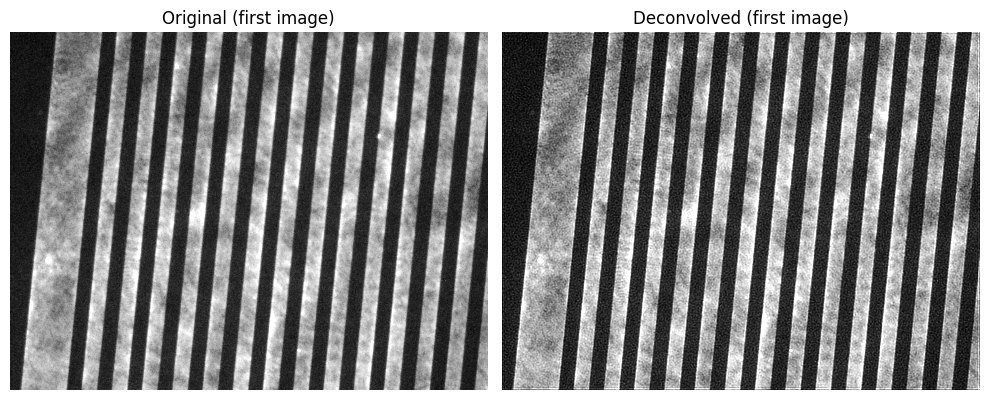

In [2]:
# ============================================
# CELL 1 — LOAD + CHECK DECONVOLUTION
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.restoration import richardson_lucy

# -----------------------------
# USER SETTINGS
# -----------------------------
#DEVONVOLUTION SETTINGS
PSF_SIGMA = 3
RL_ITERATIONS = 15

# Choose processing mode: "full" or "endpoints"
PROCESS_MODE = "full"      # options: "full", "endpoints"

IMAGE_TEMPLATE = (
    r"E:\jesper\7-11 JH101 3V 20s\Basler_acA2040-55uc__25330748__20251107_132506701_{:04d}.png"
)
IMAGE_START = 0
IMAGE_END = 30

# -----------------------------
# DECONVOLUTION FUNCTION
# -----------------------------
def deconvolve_rl(img, psf_sigma, iterations):
    size = int(psf_sigma * 8) | 1
    ax = np.arange(-(size // 2), size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)

    psf = np.exp(-(xx**2 + yy**2) / (2 * psf_sigma**2))
    psf = psf.astype(np.float32)
    psf /= psf.sum()

    img = img.astype(np.float32)
    img[img < 0] = 0
    img = np.nan_to_num(img)

    return richardson_lucy(img, psf, num_iter=iterations, clip=False)

# -----------------------------
# SELECT IMAGES BASED ON MODE
# -----------------------------
if PROCESS_MODE == "full":
    image_numbers = range(IMAGE_START, IMAGE_END + 1)

elif PROCESS_MODE == "endpoints":
    image_numbers = [IMAGE_START, IMAGE_END]

else:
    raise ValueError("PROCESS_MODE must be 'full' or 'endpoints'")

image_paths = [IMAGE_TEMPLATE.format(i) for i in image_numbers]

# -----------------------------
# LOAD + DECONVOLVE IMAGES
# -----------------------------
deconvolved_images = []

for p in image_paths:
    raw = np.array(Image.open(p).convert("F"), dtype=np.float32)
    dec = deconvolve_rl(raw, PSF_SIGMA, RL_ITERATIONS)
    deconvolved_images.append(dec)

deconvolved_images = np.array(deconvolved_images)

print("Cell 1 complete — deconvolved_images ready.")
print(f"Processed {len(deconvolved_images)} images in {PROCESS_MODE} mode.")

# -----------------------------
# SHOW BEFORE/AFTER FOR FIRST IMAGE
# -----------------------------
raw0 = np.array(Image.open(image_paths[0]).convert("F"), dtype=np.float32)
dec0 = deconvolved_images[0]

vmin = np.percentile(raw0, 1)
vmax = np.percentile(raw0, 99)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(raw0, cmap="gray", vmin=vmin, vmax=vmax)
plt.title("Original (first image)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(dec0, cmap="gray", vmin=vmin, vmax=vmax)
plt.title("Deconvolved (first image)")
plt.axis("off")

plt.tight_layout()
plt.show()


Detected stripe angle: -5.700°


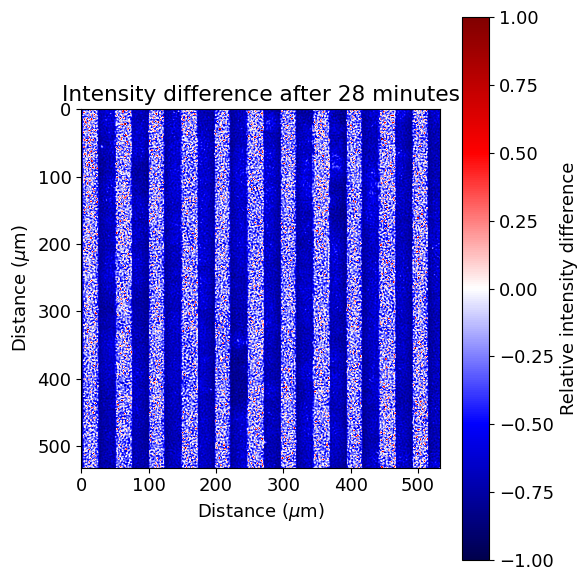

In [20]:
# ==========================================
# CELL 2 — PREPARING DATA AND PLOTTING INTENSITY DIFFERENCE HEATMAP
# ==========================================
from skimage.transform import rotate, radon, resize as imresize
from scipy.ndimage import shift, gaussian_filter
#plot font size
plt.rcParams.update({'font.size': 13})

# ---- USER SETTINGS ----
ENABLE_ZOOM = False
ZOOM_CENTER_PX = (200, 200)   # (x, y) in pixels IN THE CROPPED IMAGE
ZOOM_SIZE_PX = 400            # half-width in pixels

X_SHIFT = 0                  # horizontal shift in pixels
PIXEL_SIZE = 0.3787         # µm

# Pick the images to compare
img1 = deconvolved_images[0]
img2 = deconvolved_images[-1]

# ---- FUNCTIONS ----

def detect_stripe_angle_radon(img,
                              coarse_span=90, coarse_step=1.0,
                              fine_range=3.0, fine_step=0.1,
                              downsample=0.5, roi_frac=0.6):

    img = np.asarray(img, dtype=np.float32)
    H, W = img.shape

    rh, rw = int(H * roi_frac), int(W * roi_frac)
    y0 = (H - rh) // 2
    x0 = (W - rw) // 2
    roi = img[y0:y0+rh, x0:x0+rw]

    if downsample != 1.0:
        roi = imresize(roi,
                       (int(rh*downsample), int(rw*downsample)),
                       anti_aliasing=True,
                       preserve_range=True)

    hp = roi - gaussian_filter(roi, sigma=5)
    hp -= hp.mean()
    hp /= hp.std() + 1e-6

    angles = np.arange(-coarse_span, coarse_span, coarse_step)
    R = radon(hp, theta=angles, circle=False)
    best = angles[np.argmax(np.sum(R**2, axis=0))]

    fine = np.arange(best - fine_range, best + fine_range, fine_step)
    R2 = radon(hp, theta=fine, circle=False)

    return float(fine[np.argmax(np.sum(R2**2, axis=0))])


def rotate_with_background(img, angle, bg):
    return rotate(img, -angle, resize=True, mode="constant",
                  cval=bg, preserve_range=True, order=1)


def largest_square_in_mask(mask):
    H, W = mask.shape
    dp = np.zeros_like(mask, dtype=int)

    dp[0, :] = mask[0, :]
    dp[:, 0] = mask[:, 0]

    max_size = 0
    max_pos = (0, 0)

    for y in range(1, H):
        for x in range(1, W):
            if mask[y, x]:
                dp[y, x] = 1 + min(dp[y-1, x],
                                   dp[y, x-1],
                                   dp[y-1, x-1])
                if dp[y, x] > max_size:
                    max_size = dp[y, x]
                    max_pos = (y, x)

    y1, x1 = max_pos
    side = max_size

    return y1 - side + 1, x1 - side + 1, side


# ---- PROCESSING PIPELINE ----

BG = max(img1.max(), img2.max())

angle = detect_stripe_angle_radon(img1)
print(f"Detected stripe angle: {angle:.3f}°")

img1r = rotate_with_background(img1, angle, BG)
img2r = rotate_with_background(img2, angle, BG)

# Optional subpixel shift
img2r = shift(img2r, shift=(0, X_SHIFT), mode="nearest", order=1)

mask1 = rotate(np.ones_like(img1), -angle, resize=True,
               mode="constant", cval=0).astype(bool)
mask2 = rotate(np.ones_like(img2), -angle, resize=True,
               mode="constant", cval=0).astype(bool)

valid = mask1 & mask2
y0, x0, side = largest_square_in_mask(valid)

img1_crop = img1r[y0:y0+side, x0:x0+side]
img2_crop = img2r[y0:y0+side, x0:x0+side]

diff = (img2_crop - img1_crop) / (img1_crop + 1e-6)

# ---- PHYSICAL AXES ----

height, width = diff.shape

# ---- PLOTTING ----

# ---- PLOTTING ----

fig, ax = plt.subplots(figsize=(6,6))

im = ax.imshow(
    diff,
    cmap="seismic",
    vmin=-1, vmax=1,
    extent=[0, width * PIXEL_SIZE, height * PIXEL_SIZE, 0]
)

# ---- APPLY ZOOM ----

if ENABLE_ZOOM:
    cx, cy = ZOOM_CENTER_PX
    half = ZOOM_SIZE_PX

    x1 = (cx - half) * PIXEL_SIZE
    x2 = (cx + half) * PIXEL_SIZE
    y1 = (cy - half) * PIXEL_SIZE
    y2 = (cy + half) * PIXEL_SIZE

    ax.set_xlim(x1, x2)
    ax.set_ylim(y2, y1)

# ---- TICKS ----
# IMPORTANT: ticks must be inside zoom window!

if ENABLE_ZOOM:
    ax.set_xticks(np.linspace(x1, x2, 5))
    ax.set_yticks(np.linspace(y2, y1, 5))
else:
    tick_step = 100
    ax.set_xticks(np.arange(0, width * PIXEL_SIZE, tick_step))
    ax.set_yticks(np.arange(0, height * PIXEL_SIZE, tick_step))

# ---- LABELS ----

plt.colorbar(im, label="Relative intensity difference")

ax.set_xlabel("Distance ($\\mu$m)")
ax.set_ylabel("Distance ($\\mu$m)")
ax.set_title("Intensity difference after 28 minutes")

plt.tight_layout()
plt.show()



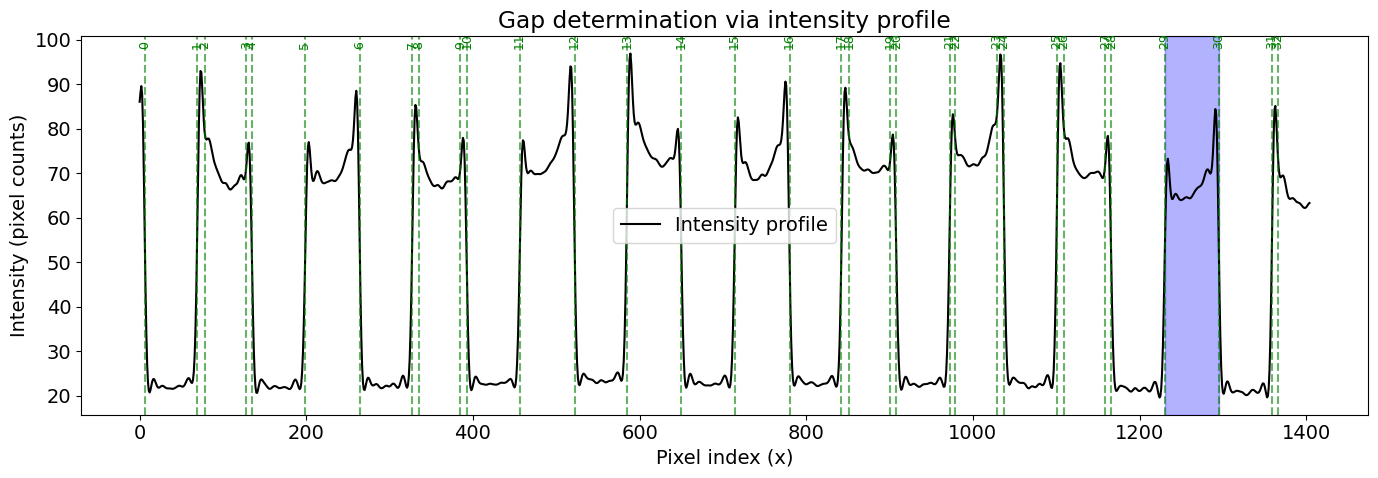

Gap size: 65.00 pixels
1295
1230


In [ ]:
# ==========================================
# CELL 3 — INTENSITY-BASED MIDPOINTS + GAP SELECTION
# ==========================================


from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
plt.rcParams.update({'font.size': 14})
# USER SETTINGS
LEFT_MIDPOINT_INDEX  = 29
RIGHT_MIDPOINT_INDEX = 30
#LIMITS TO SELECT THE RIGHT GAPS
SMOOTH_SIGMA = 1
PEAK_PROMINENCE = 1
PEAK_DISTANCE = 30
# BUILD REAL INTENSITY PROFILE
profile = img1_crop.mean(axis=0)
profile = gaussian_filter1d(profile, SMOOTH_SIGMA)
x = np.arange(len(profile))
# DETECT EXTREMA
maxima, _ = find_peaks(
    profile,
    prominence=PEAK_PROMINENCE,
    distance=PEAK_DISTANCE)
minima, _ = find_peaks(
    -profile,
    prominence=PEAK_PROMINENCE,
    distance=PEAK_DISTANCE)
# (x_position, type)
extrema = (
    [(i,  1) for i in maxima] +
    [(i, -1) for i in minima])
extrema.sort(key=lambda t: t[0])
# BUILD INTENSITY-BASED MIDPOINTS
midpoints = []
for (x0, t0), (x1, t1) in zip(extrema[:-1], extrema[1:]):
    # only max ↔ min transitions
    if t0 == t1:
        continue
    y0 = profile[x0]
    y1 = profile[x1]
    y_mid = 0.5 * (y0 + y1)
    # search between extrema for closest crossing
    xs = np.arange(x0, x1 + 1)
    ys = profile[xs]
    idx = np.argmin(np.abs(ys - y_mid))
    x_mid = xs[idx]
    midpoints.append(x_mid)
midpoints = np.array(midpoints)
# SAFETY CHECK
if not (0 <= LEFT_MIDPOINT_INDEX < RIGHT_MIDPOINT_INDEX < len(midpoints)):
    raise ValueError("Invalid midpoint indices selected")
# SELECT GAP
g0 = midpoints[LEFT_MIDPOINT_INDEX]
g1 = midpoints[RIGHT_MIDPOINT_INDEX]
# PLOT
plt.figure(figsize=(14, 5))
plt.plot(profile, color="black", label="Intensity profile")
y_text = profile.max() + 1
for i, m in enumerate(midpoints):
    plt.axvline(m, color='green', linestyle='--', alpha=0.6)
    plt.text(m, y_text, str(i),
             color='green', fontsize=9,
             ha='center', va='bottom', rotation=90)
plt.axvspan(g0, g1, color='blue', alpha=0.3)
plt.title("Gap determination via intensity profile")
plt.xlabel("Pixel index (x)")
plt.ylabel("Intensity (pixel counts)")
plt.legend()
plt.tight_layout()
plt.show()
print(f"Gap size: {g1 - g0:.2f} pixels")
print(g0)
print(g1)


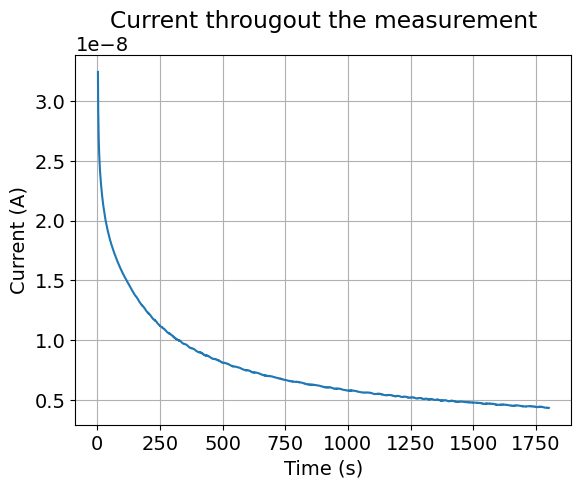

In [22]:
# ==========================================
# CELL 4 — CURRENT PLOTTING
# ==========================================
plt.rcParams.update({'font.size': 14})
Time= np.loadtxt("E:/jesper/18-12 JH016 -4V 20s/current.txt", usecols=0, skiprows=1)
Current= -np.loadtxt("E:/jesper/18-12 JH016 -4V 20s/current.txt", usecols=1, skiprows=1)
plt.plot(Time, Current)
plt.xlabel("Time (s)")
plt.ylabel('Current (A)')
plt.title('Current througout the measurement')
plt.grid()
plt.show()


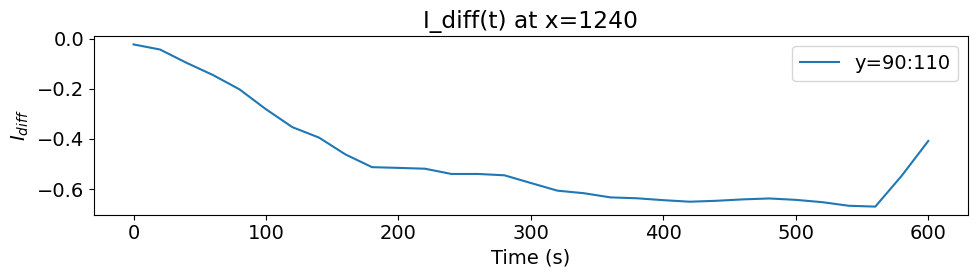

In [ ]:
# ---------------------------------------------------
#CELL 5 - PLOT Idiff FOR SELECTED X-POINTS AVERAGED IN Y OVER TIME
# ---------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

# ============================================
# USER SETTINGS
# ============================================


# Define your own y-sections as (y_start, y_end)
Y_SECTIONS = [(90, 110)]

# Define x-positions (pixel indices)
X_POSITIONS = [g0+10] #g0 = left side of your selected gap

DT = 20  # time step
USE_BOXCAR = True
BOXCAR_WIDTH = 5

# X-range selection
x0_sel, x1_sel = (g0, g1)

# ============================================
# PREPARE
# ============================================
I0 = rotated_cropped[0]

P_xt = []

for t in range(T):
    It = rotated_cropped[t]
    P = (It - I0) / (I0 + 1e-6)
    P_xt.append(P)

P_xt = np.array(P_xt)
T, H, W = P_xt.shape
time = np.arange(T) * DT

# Boxcar kernel
if USE_BOXCAR:
    kernel = np.ones(BOXCAR_WIDTH) / BOXCAR_WIDTH

# ============================================
# PLOTTING
# ============================================

fig, axes = plt.subplots(len(X_POSITIONS), 1,
                         figsize=(10, 3 * len(X_POSITIONS)),
                         sharex=True)

if len(X_POSITIONS) == 1:
    axes = [axes]

for ax, x_pos in zip(axes, X_POSITIONS):

    # Check x-position validity
    if not (x0_sel <= x_pos < x1_sel):
        ax.set_title(f"x={x_pos} outside selected range")
        continue

    for (y0, y1) in Y_SECTIONS:

        # Extract I_diff(t) for this y-section and x-position
        I_t = []
        for t in range(T):
            sec = P_xt[t][y0:y1, x0_sel:x1_sel]   # crop y-section + x-range
            sec_mean = sec.mean(axis=0)          # average over y
            I_t.append(sec_mean[x_pos - x0_sel]) # pick x-position

        I_t = np.array(I_t)

        # Optional smoothing
        if USE_BOXCAR:
            I_t = np.convolve(I_t, kernel, mode='same')

        ax.plot(time, I_t, label=f"y={y0}:{y1}")

    ax.set_title(f"I_diff(t) at x={x_pos}")
    ax.set_ylabel("$I_{diff}$")
    ax.legend()

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()


<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
C:\Users\jespe\AppData\Local\Temp\ipykernel_10204\373613257.py:40: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("x position ($\mu m$)")


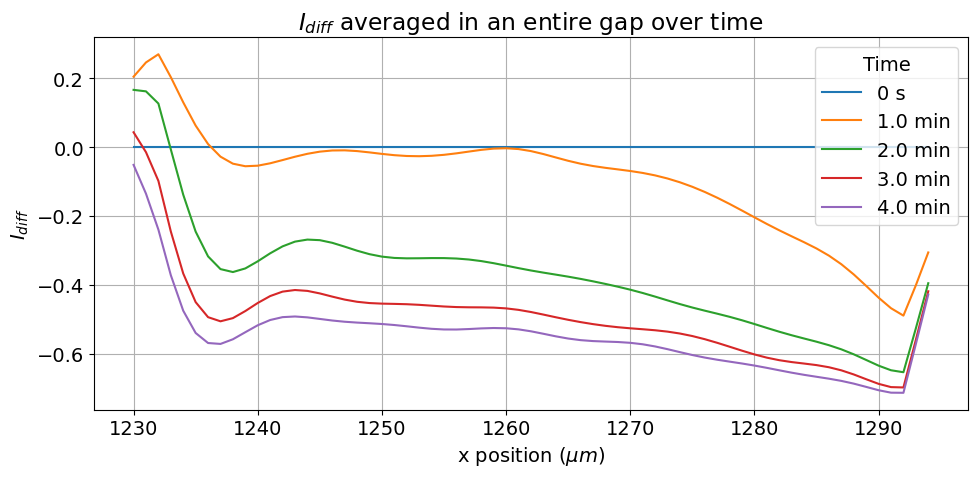

In [34]:
# ---------------------------------------------------
# CELL 6 - Idiff OVER WHOLE GAP AVERAGED OVER ENTIRE Y
# ---------------------------------------------------
plt.rcParams.update({'font.size': 14})
X_RANGE_SINGLE = (g0, g1)        # x boundaries
TIMES_TO_PLOT = [0, 3, 6, 9, 12]   # frame indices

x0_s, x1_s = X_RANGE_SINGLE

plt.figure(figsize=(10, 5))

for t in TIMES_TO_PLOT:

    # Average over ALL y-values at time t
    row_mean = P_xt[t].mean(axis=0)   # shape: (W,)

    # Select x-range safely
    slice_x = row_mean[x0_s:x1_s]

    # Optional boxcar smoothing
    if USE_BOXCAR:
        slice_x = np.convolve(slice_x, kernel, mode='same')

    # x-axis in micrometers (same as before)
    xs_local = np.arange(len(slice_x)) + x0_s
    xs_um = xs_local 

    # Convert frame index to real time
    time_seconds = t * DT
    time_minutes = time_seconds / 60

    # Format legend label
    if time_minutes < 1:
        label = f"{time_seconds:.0f} s"
    else:
        label = f"{time_minutes:.1f} min"

    plt.plot(xs_um, slice_x, label=label)

plt.xlabel("x position ($\mu m$)")
plt.ylabel("$I_{diff}$")
plt.title("$I_{diff}$ averaged in an entire gap over time")
plt.legend(title="Time")
plt.grid()
plt.tight_layout()
plt.show()


<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
C:\Users\jespe\AppData\Local\Temp\ipykernel_10204\3023046898.py:61: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("x position ($\mu m$)")


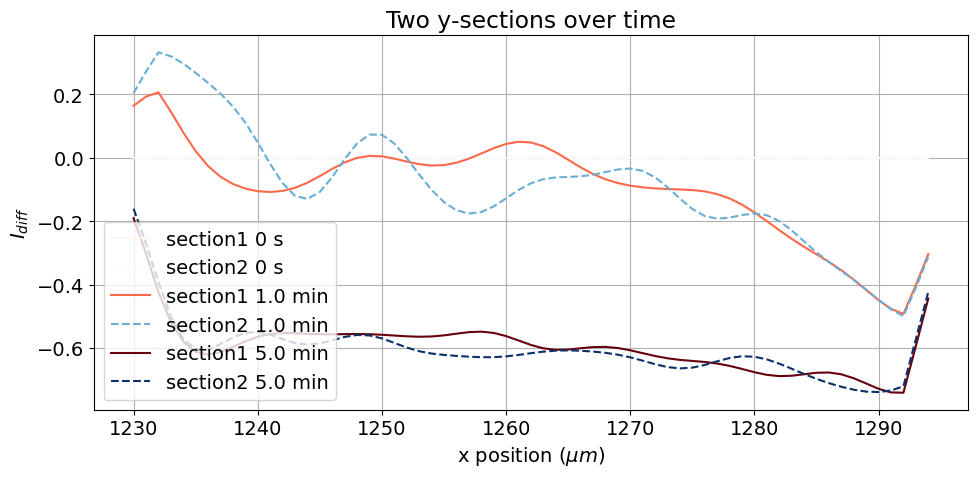

In [ ]:
# ---------------------------------------------------
#CELL 7 - Idiff OVER ENTIRE GAP FOR SELECTED Y-SECTIONS AND TIMES
# ---------------------------------------------------

plt.rcParams.update({'font.size': 14})

# Define two y‑sections (ranges)
# Example: earlier you used something like Y_RANGE_1 = (y0, y1)
Y_RANGE_1 = (456, 576)   # replace with your section 1
Y_RANGE_2 = (1046, 1066)   # replace with your section 2

# Times to plot
TIMES_TO_PLOT = [ 0,3,15]

# X‑range (same gap as before)
x0_s, x1_s = (g0, g1)

# Color maps for smooth shading
cmap_red = plt.cm.Reds
cmap_blue = plt.cm.Blues

plt.figure(figsize=(10, 5))

for idx, t in enumerate(TIMES_TO_PLOT):

    # Normalized index for color shading
    c_norm = idx / max(len(TIMES_TO_PLOT)-1, 1)

    # Extract slices averaged over y‑sections
    y0_1, y1_1 = Y_RANGE_1
    y0_2, y1_2 = Y_RANGE_2

    slice1 = P_xt[t][y0_1:y1_1, x0_s:x1_s].mean(axis=0)
    slice2 = P_xt[t][y0_2:y1_2, x0_s:x1_s].mean(axis=0)

    # Optional smoothing
    if USE_BOXCAR:
        slice1 = np.convolve(slice1, kernel, mode='same')
        slice2 = np.convolve(slice2, kernel, mode='same')

    # x‑axis
    xs_local = np.arange(len(slice1)) + x0_s
    xs_um = xs_local

    # Time label
    time_seconds = t * DT
    time_minutes = time_seconds / 60
    label = f"{time_seconds:.0f} s" if time_minutes < 1 else f"{time_minutes:.1f} min"

    # Plot section 1 (red shades)
    plt.plot(xs_um, slice1,
             color=cmap_red(c_norm),
             label=f"section1 {label}")

    # Plot section 2 (blue shades)
    plt.plot(xs_um, slice2,
             color=cmap_blue(c_norm),
             linestyle='--',
             label=f"section2 {label}")

plt.xlabel("x position ($\mu m$)")
plt.ylabel("$I_{diff}$")
plt.title("Two y‑sections over time")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


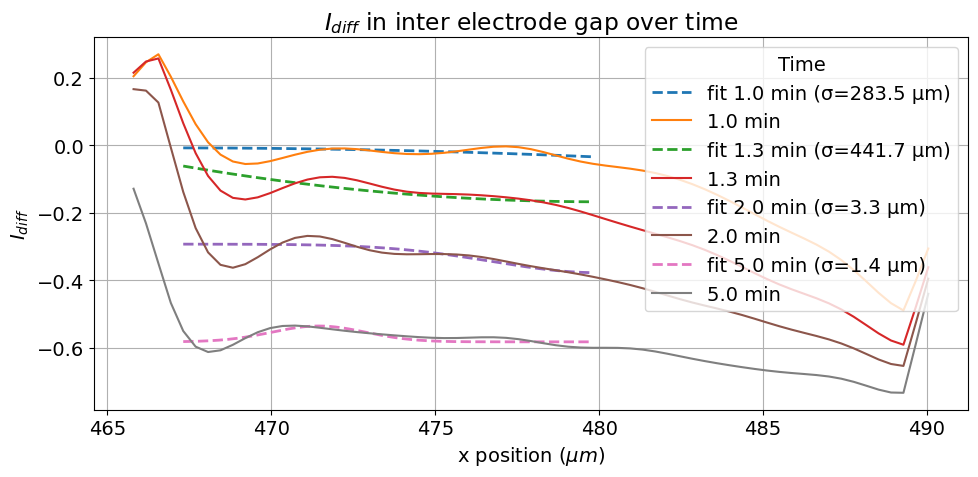

In [ ]:
# ============================================
# CELL 8 — I_diff(x,t) +  HALF-GAUSSIAN FITS
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------------------------------------------------
# Half-Gaussian model
# ---------------------------------------------------
def half_gaussian(x, A, x0, sigma, C):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2)) + C

# ---------------------------------------------------
# USER SETTINGS
# ---------------------------------------------------
TIMES_TO_PLOT = [3,4,6,15]   # frames to show
FIT_RANGE_X = (467, 480)    # µm region where Gaussian tail exists

# ---------------------------------------------------
# PLOT I_diff(x,t) WITH GAUSSIAN FITS
# ---------------------------------------------------
plt.figure(figsize=(10, 5))
x0_s, x1_s = int(g0), int(g1)

for t in TIMES_TO_PLOT:

    # Average over all y
    slice_x = P_xt[t].mean(axis=0)[x0_s:x1_s]

    if USE_BOXCAR:
        slice_x = np.convolve(slice_x, kernel, mode='same')

    xs_local = np.arange(len(slice_x)) + x0_s
    xs_um = xs_local * PIXEL_SIZE

    # Time label
    time_seconds = t * DT
    time_minutes = time_seconds / 60
    label = f"{time_seconds:.0f} s" if time_minutes < 1 else f"{time_minutes:.1f} min"

    # -----------------------------
    # Select forced fit region
    # -----------------------------
    mask = (xs_um >= FIT_RANGE_X[0]) & (xs_um <= FIT_RANGE_X[1])
    x_fit_data = xs_um[mask]
    y_fit_data = slice_x[mask]

    # If empty, expand automatically
    if len(x_fit_data) < 5:
        idx = np.argsort(np.abs(xs_um - np.mean(FIT_RANGE_X)))[:8]
        x_fit_data = xs_um[idx]
        y_fit_data = slice_x[idx]

    # -----------------------------
    # Forced initial guesses
    # -----------------------------
    A0 = (y_fit_data.min() - y_fit_data.max()) or -0.1
    x0_0 = x_fit_data[np.argmin(y_fit_data)]
    sigma0 = max((x_fit_data[-1] - x_fit_data[0]) / 3, 1e-3)
    C0 = y_fit_data.max()

    p0 = [A0, x0_0, sigma0, C0]

    # -----------------------------
    # Fit Gaussian (forced)
    # -----------------------------
    try:
        popt, pcov = curve_fit(
            half_gaussian, x_fit_data, y_fit_data, p0=p0,
            bounds=([-np.inf, FIT_RANGE_X[0], 0, -np.inf],
                    [ np.inf, FIT_RANGE_X[1], np.inf,  np.inf])
        )
    except:
        # fallback: fix x0 and sigma
        def fallback(x, A, C):
            return A * np.exp(-(x - x0_0)**2 / (2 * sigma0**2)) + C
        popt2, _ = curve_fit(fallback, x_fit_data, y_fit_data, p0=[A0, C0])
        popt = [popt2[0], x0_0, sigma0, popt2[1]]

    A_fit, x0_fit, sigma_fit, C_fit = popt

    # Smooth curve
    x_smooth = np.linspace(x_fit_data.min(), x_fit_data.max(), 300)
    y_smooth = half_gaussian(x_smooth, *popt)

    # Plot fits + data
    plt.plot(x_smooth, y_smooth, '--', linewidth=2,
             label=f"fit {label} (σ={sigma_fit:.1f} µm)")
    plt.plot(xs_um, slice_x, label=label)

plt.xlabel(r"x position ($\mu m$)")
plt.ylabel("$I_{diff}$")
plt.title("$I_{diff}$ in inter electrode gap over time")
plt.legend(title="Time")
plt.grid()
plt.tight_layout()
plt.show()


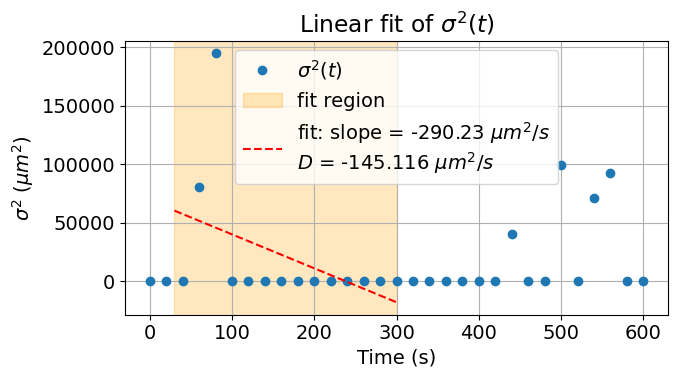

Slope = -290.2318 µm²/s
Diffusion coefficient D = -145.1159 µm²/s


In [ ]:
# ============================================
# CELL 9 — Linear fit of sigma^2 in selected window
# ============================================
# -----------------------------
# USER: SELECT FIT RANGE (seconds)
# -----------------------------
T_FIT_MIN = 30     # start time [s]
T_FIT_MAX = 300    # end time   [s]

sigma_list = []
time_list = []

x0_s, x1_s = int(g0), int(g1)

# Use ALL time frames
TIMES_TO_PLOT = np.arange(P_xt.shape[0])

for t in TIMES_TO_PLOT:

    slice_x = P_xt[t].mean(axis=0)[x0_s:x1_s]

    if USE_BOXCAR:
        slice_x = np.convolve(slice_x, kernel, mode='same')

    xs_local = np.arange(len(slice_x)) + x0_s
    xs_um = xs_local * PIXEL_SIZE

    mask = (xs_um >= FIT_RANGE_X[0]) & (xs_um <= FIT_RANGE_X[1])
    x_fit_data = xs_um[mask]
    y_fit_data = slice_x[mask]

    if len(x_fit_data) < 5:
        idx = np.argsort(np.abs(xs_um - np.mean(FIT_RANGE_X)))[:8]
        x_fit_data = xs_um[idx]
        y_fit_data = slice_x[idx]

    A0 = (y_fit_data.min() - y_fit_data.max()) or -0.1
    x0_0 = x_fit_data[np.argmin(y_fit_data)]
    sigma0 = max((x_fit_data[-1] - x_fit_data[0]) / 3, 1e-3)
    C0 = y_fit_data.max()

    p0 = [A0, x0_0, sigma0, C0]

    try:
        popt, _ = curve_fit(
            half_gaussian, x_fit_data, y_fit_data, p0=p0,
            bounds=([-np.inf, FIT_RANGE_X[0], 0, -np.inf],
                    [ np.inf, FIT_RANGE_X[1], np.inf,  np.inf])
        )
    except:
        def fallback(x, A, C):
            return A * np.exp(-(x - x0_0)**2 / (2 * sigma0**2)) + C
        popt2, _ = curve_fit(fallback, x_fit_data, y_fit_data, p0=[A0, C0])
        popt = [popt2[0], x0_0, sigma0, popt2[1]]

    _, _, sigma_fit, _ = popt

    sigma_list.append(sigma_fit)
    time_list.append(t * DT)

sigma_arr = np.array(sigma_list)
time_arr = np.array(time_list)


# -----------------------------
# Select fit window
# -----------------------------
mask = (time_arr >= T_FIT_MIN) & (time_arr <= T_FIT_MAX)
t_fit = time_arr[mask]
sigma2_fit = (sigma_arr**2)[mask]

# -----------------------------
# Linear fit
# -----------------------------
coeffs = np.polyfit(t_fit, sigma2_fit, 1)
slope, intercept = coeffs

# Diffusion coefficient:  sigma^2 = 2 D t + sigma0^2
D = slope / 2

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(7,4))

# Full dataset
plt.plot(time_arr, sigma_arr**2, 'o', label=r'$\sigma^2(t)$')

# Highlighted region
plt.axvspan(T_FIT_MIN, T_FIT_MAX, color='orange', alpha=0.25, label="fit region")

# Fit line
t_line = np.linspace(T_FIT_MIN, T_FIT_MAX, 200)
plt.plot(t_line, slope * t_line + intercept, 'r--',
         label=fr"fit: slope = {slope:.2f} $\mu m^2/s$"+"\n"+fr"$D$ = {D:.3f} $\mu m^2/s$")

plt.xlabel("Time (s)")
plt.ylabel(r"$\sigma^2$ ($\mu m^2$)")
plt.title(r"Linear fit of $\sigma^2(t)$")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"Slope = {slope:.4f} µm²/s")
print(f"Diffusion coefficient D = {D:.4f} µm²/s")
